# Text Processing with spaCy

In [151]:
from pymongo import MongoClient
from configparser import ConfigParser
from collections import Counter
import numpy as np
import pandas as pd
import gzip
import pickle
import warnings
import sys
import os
from collections import defaultdict

# text pre-processing
import re
import string
punctuations = string.punctuation
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    import spacy
    nlp = spacy.load('en')


# matplotlib
import matplotlib.pyplot as plt
from matplotlib import patches
from mpl_toolkits.mplot3d import Axes3D
% matplotlib inline

# plotly
import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# sklearn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD, PCA, NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS as stopwords 
from sklearn.preprocessing import Normalizer, StandardScaler

os.chdir('/Users/tmoeller/ds/twitter-project/partisan-tweets')
import src.data.aws_ec2_functions as aws

In [2]:
print('Python', sys.version)
print('Pandas', pd.__version__)
print('Numpy', np.__version__)
print('SpaCy', spacy.__version__)
print('Plotly', plotly.__version__)

Python 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas 0.20.3
Numpy 1.14.1
SpaCy 2.0.8
Plotly 2.4.1


In [9]:
instance = aws.fetch_instances()[0]

## Read in tweet data from Mongodb

In [11]:
config = ConfigParser()
config.read('config.ini')

client = MongoClient("mongodb://{}:{}@{}/{}".format(
                        config.get('MongoConfig', 'user'),
                        config.get('MongoConfig', 'password'),
                        instance.public_ip_address,
                        config.get('MongoConfig', 'db')
                        ), int(config.get('MongoConfig', 'port')))

In [12]:
db = client.twitter_db

In [13]:
db.collection_names()

['tweets',
 'favorited_tweets',
 'train_test_dict',
 'fav_tweets_dict',
 'Init',
 'legislator_tweets_dict']

In [14]:
db.tweets.count()

30340

Let's pull out 20K random tweets from our group of legislators

In [16]:
# Read in political affiliation by legislator 
with open('data/raw/parties.pickle', 'rb') as file:
    legislator_party = pickle.load(file)

In [17]:
len(legislator_party)

524

In [18]:
relevant_legislators = [sn for sn in legislator_party if legislator_party[sn] != 'Independent']
len(relevant_legislators)

522

Because I'm only interested in Republicans and Democrats, let's remove Bernie and that one other Independent party legislator from our group

In [19]:
cursor = db.tweets.find({})

In [20]:
tweet_data = [doc for doc in cursor]

In [21]:
len(tweet_data)

30340

In [22]:
tweet_en = [doc for doc in tweet_data if doc['lang']=='en']
len(tweet_en)

29891

In [23]:
np.random.seed(42)
tweet_sample = np.random.choice(tweet_en, size=20000, replace=False)

In [24]:
rawtext = [tweet['full_text'] for tweet in tweet_sample]

rawtext[:5]

["No father should be charged for this reaction to his daughters' abuse!  https://t.co/AwztDvSP8b",
 "Constituent input is critical to my work in Congress. On issues like job growth and healthcare, I want to hear your ideas, answer your questions, and talk about our priorities. That's why I'm inviting you to join my next town hall. RSVP here: https://t.co/QiGfM5TKe9 https://t.co/wSav2TVhwu",
 'Joining @RepLynnJenkins at @DaVita in Topeka. The facility, whose opening has been delayed for years, is finally opening after our legislation to speed up accreditation and improve patient access was signed into law. https://t.co/4NO31mlx0P',
 '3 out of 4 Pinocchios, Mr. President. Your solar tax is a job killer. #SaveSolarJobs https://t.co/2dLFs1K7mg',
 "Unborn children can feel pain as early as 20 wks. Only the US &amp; six other nations – China &amp; North Korea among them – allow elective abortions past 20 wks. Tonight, I'll vote for the #Senate to proceed to consideration of the Pain-Capable

In [62]:
names = [tweet['user']['screen_name'] for tweet in tweet_sample]

## Normalize Text

#### Clean, Tokenize and Vectorize (maybe Stem, Lemmatize)

In [25]:
def clean_tweet(tweet):
    """
    Function to remove urls, numbers and punctuation, and make lowercase
    """
    no_url = re.sub(r'http\S+', '', tweet)
    clean = re.sub(r'[^\w\s]', '', no_url)
    
    result = ''.join([str(i).replace('\n', ' ').lower() for i in clean if not i.isdigit()])

    return result

In [26]:
cleantext = [clean_tweet(i) for i in rawtext]
print(rawtext[3], '\n')
print(cleantext[3])

3 out of 4 Pinocchios, Mr. President. Your solar tax is a job killer. #SaveSolarJobs https://t.co/2dLFs1K7mg 

 out of  pinocchios mr president your solar tax is a job killer savesolarjobs 


In [234]:
def spacy_tokenizer(tweet):
    """
    Utility function to remove stopwords, ignore pronouns and tokenize words before vectorizing
    """
    doc = nlp(tweet)
    tokens = [token.orth_ for token in doc if 
              (token.orth_ not in stopwords and token.pos_ in ['NOUN', 'PROPN'] and not token.orth_ in ['amp', 'today'])]
            
    return tokens

In [235]:
print(cleantext[1])

tokens_test = spacy_tokenizer(cleantext[1])
tokens_test

constituent input is critical to my work in congress on issues like job growth and healthcare i want to hear your ideas answer your questions and talk about our priorities thats why im inviting you to join my next town hall rsvp here  


['constituent',
 'input',
 'work',
 'congress',
 'issues',
 'job',
 'growth',
 'healthcare',
 'ideas',
 'questions',
 'priorities',
 'town',
 'hall',
 'rsvp']

In [236]:
#create vectorizer object to generate feature vectors, we will use custom spacy’s tokenizer
vectorizer = TfidfVectorizer(tokenizer = spacy_tokenizer, 
                             ngram_range=(1,1))

In [237]:
vectorizer.fit(cleantext)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function spacy_tokenizer at 0x1254f29d8>, use_idf=True,
        vocabulary=None)

In [238]:
dtm = vectorizer.transform(cleantext)

In [239]:
np.shape(dtm)

(20000, 18072)

In [240]:
id2word = dict((v, k) for k, v in vectorizer.vocabulary_.items())

In [241]:
len(id2word)

18072

In [35]:
with open('data/processed/legislator_word_features.pkl', 'wb') as wf:
    pickle.dump(id2word, wf)

# Dimensionality Reduction and Topic Modeling for Small Data

I've chosen to try LSA and NMF for topic modeling because LDA is best used on large documents

In [242]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("\nTopic #%d:" % topic_idx)
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
    print()

## Try LSA

In [243]:
lsa = TruncatedSVD(n_components=4, random_state=42, algorithm = 'arpack')
dtm_lsa = lsa.fit_transform(dtm)
dtm_lsa = Normalizer(copy=False).fit_transform(dtm_lsa)

In [244]:
lsa.explained_variance_ratio_

array([0.0028721 , 0.00510504, 0.0046794 , 0.00393297])

In [245]:
print_top_words(lsa, vectorizer.get_feature_names(), 15)


Topic #0:
president people congress tax americans families trump health country potus time gun house violence year

Topic #1:
tax cuts taxreform reform jobs workers bonuses americans benefits taxcutsandjobsact employees thanks news paychecks businesses

Topic #2:
gun violence families school students victims prayers parkland florida congress thoughts community responders action shooting

Topic #3:
health care community centers funding budget veterans work access agreement americans insurance center quality deal



## Try NMF

In [246]:
nmf = NMF(n_components=10, random_state=42)

dtm_nmf = nmf.fit_transform(dtm)
dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)

In [247]:
print_top_words(nmf, vectorizer.get_feature_names(), 100)


Topic #0:
president trump trumps russia birthday administration sanctions security states democracy elections tonight reagan congress law year lincoln investigation proposal election leadership interference immigration infrastructure promises obama address director campaign administrations years rule attack fbi republicans policy ronald message crisis america attacks presidentsday workers admin abraham deficit mr threat actions putin fact russians efforts decision vision korea wall plan budget words nations speech promise russias justice counsel programs mueller border issue action reagans meddling night ayearoftrump sotu rhetoric credit vice nation george shutdown intelligence agenda office daca muellers department letter thing thingstrumpwonttalkabout nunesmemo response north goptaxscam epidemic reality americas enforcement candidate

Topic #1:
tax cuts reform taxreform jobs workers bonuses benefits taxcutsandjobsact americans employees news paychecks businesses thanks companies gop

The art is in first decideing what nubmer of topics to select and then in assigning each topic a name, which I'll do below

In [248]:
topics = ['Trump Administration',
          'Taxes',
          'Gun Control',
          'Health Care',
          'Memo FBI',
          'Holidays/Honoring',
          'Immigration',
          'Thoughts & Prayers',
          'America/Random',
          'SOTU']

## Try to build a word cloud on words in topic

In [249]:
def word_frequency_dict(model, feature_names, topic_names, n_top_words):
    all_dicts = defaultdict(dict)
    for topic_idx, topic in enumerate(model.components_):
        name = topic_names[topic_idx]
        all_dicts[name] = defaultdict()
        
        for i in topic.argsort()[:-n_top_words - 1:-1]:
            all_dicts[name][feature_names[i]] = topic[i]
        
    return all_dicts

In [250]:
topic_words_dict = word_frequency_dict(nmf, vectorizer.get_feature_names(), topics, 1000)

In [265]:
from wordcloud import WordCloud
from PIL import Image


In [269]:
def generate_cloud(frequency_dict):

    cloud_mask = np.array(Image.open("static/cloud-mask2.png"))
    
    for topic in frequency_dict.keys():
        print('\n', topic)
        wordcloud = WordCloud(background_color="white",
                              max_words=1000,
                              relative_scaling=0,
                              normalize_plurals=False,
                              mask=cloud_mask)
        
        wordcloud.generate_from_frequencies(topic_words_dict[topic])

        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()


In [270]:
    cloud_mask = np.array(Image.open("static/cloud_mask.png"))
cloud_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)


 Trump Administration


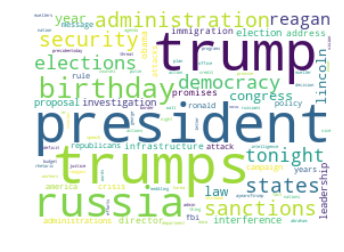


 Taxes


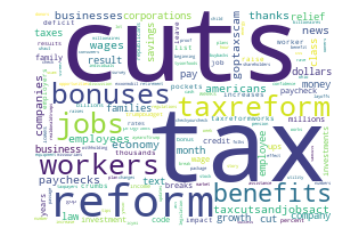


 Gun Control


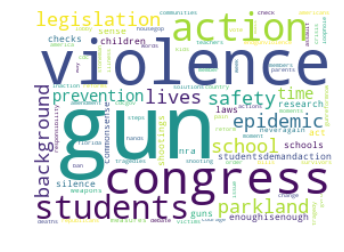


 Health Care


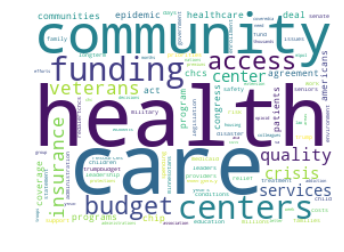


 Memo FBI


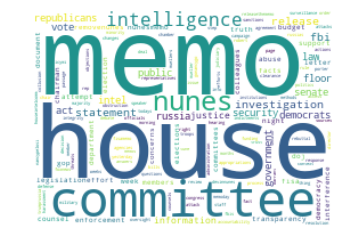


 Holidays/Honoring


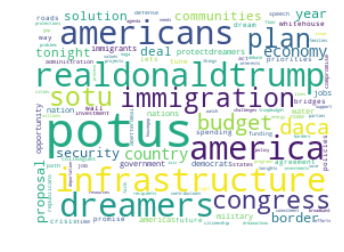


 Immigration


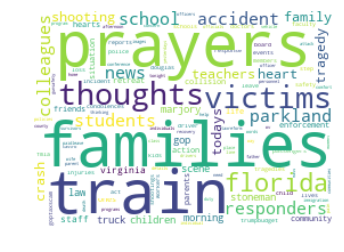


 Thoughts & Prayers


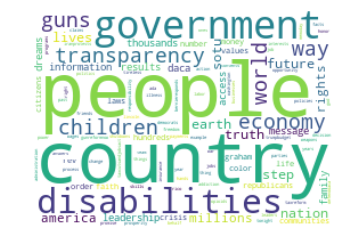


 America/Random


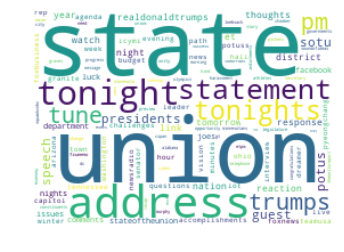


 SOTU


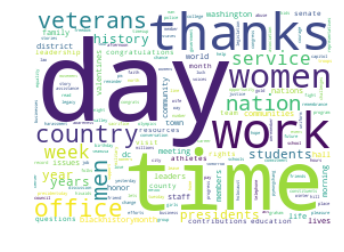

In [271]:
generate_cloud(topic_words_dict)

In [172]:
tsne = TSNE(random_state=3211)
tsne_embedding = tsne.fit_transform(dtm_nmf)

In [173]:
tsne_embedding = pd.DataFrame(tsne_embedding,columns=['x','y'])
tsne_embedding['hue'] = dtm_nmf.argmax(axis=1)

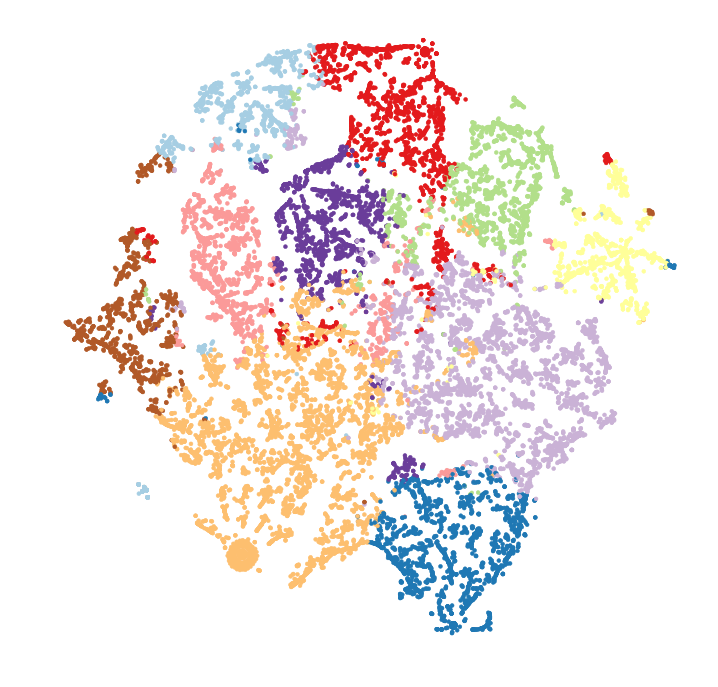

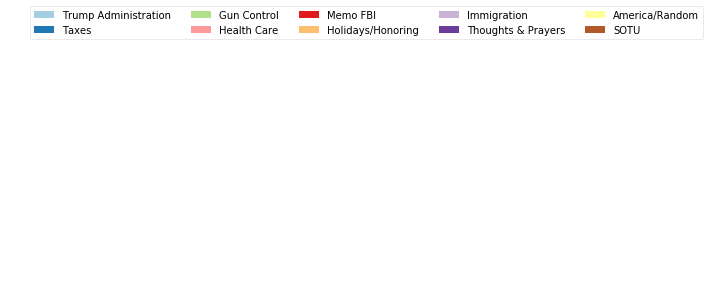

In [174]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=15,c=data['hue'],cmap="Paired")
plt.axis('off')
plt.show()

# Show legend - need to reformat
colors = []
for i in range(len(topics)):
    idx = np.where(data['hue']==i)[0][0]
    color = scatter.get_facecolors()[idx]
    colors.append(color)
    legend_list.append(patches.Ellipse((0, 0), 1, 1, fc=color))
 
plt.legend(legend_list,topics,loc=(0,1),ncol=5, facecolor="white")
plt.axis('off')
plt.show()

# Plot clusters by political affiliation

Find how many tweets per user

In [47]:
from collections import Counter

users_tweets = [tw['user']['screen_name'] for tw in tweet_sample]
print(len(set(users_tweets)), 'Distinct Users')
Counter(users_tweets).most_common(10)

514 Distinct Users


[('SenWhitehouse', 213),
 ('RepRoKhanna', 206),
 ('RepDonBeyer', 170),
 ('FrankPallone', 157),
 ('WhipHoyer', 155),
 ('senrobportman', 152),
 ('SenBlumenthal', 149),
 ('SenTinaSmith', 149),
 ('RepMaloney', 148),
 ('RepJayapal', 147)]

Find how many tweets in each party

In [48]:
tweet_party = [legislator_party[tw['user']['screen_name'].lower()] for tw in tweet_sample]

In [49]:
Counter(tweet_party)

Counter({'Democrat': 11702, 'Independent': 107, 'Republican': 8191})

Let's make the same 2D topic plot we did above but instead of coloring by topic let's color by the assumed political affiliation to see if there are differences in party density between the two classes

In [50]:
#tsne_embedding['party'] = [(1, 0, 0) if tw=='R' else (0, 0, 1) for tw in tweet_party]
tsne_embedding['party'] = ['red' if tw=='Republican' else 'blue' if tw=='Democrat' else 'green' for tw in tweet_party]

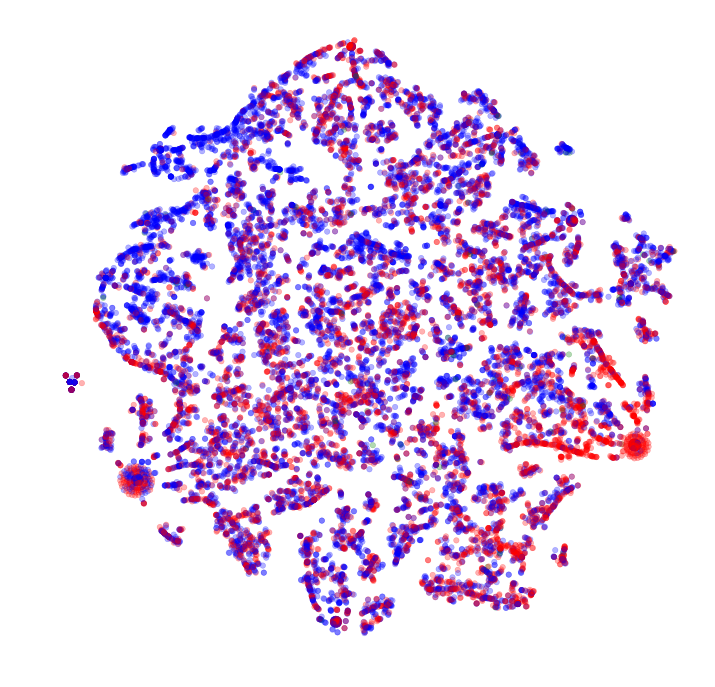

In [51]:
###code used to create the first plot for getting the colors 
plt.style.use('ggplot')

fig, axs = plt.subplots(1,1, figsize=(12, 12), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .1, wspace=.001)
    
legend_list = []

data = tsne_embedding
scatter = plt.scatter(data=data,x='x',y='y',s=30, alpha=.3, color=data['party'])
plt.axis('off')
plt.show()

## Try plotting in 3D

In [52]:
tsne = TSNE(n_components=3, random_state=3211)
tsne_result = tsne.fit_transform(dtm_nmf)

In [53]:
tsne_result_scaled = StandardScaler().fit_transform(tsne_result)

tsne_result_scaled_df = pd.DataFrame(tsne_result_scaled,columns=['x','y','z'])
tsne_result_scaled_df['hue'] = dtm_nmf.argmax(axis=1)

In [54]:
label_to_id_dict = {v:i for i,v in enumerate(list(topics))}
id_to_label_dict = {v: k for k, v in label_to_id_dict.items()}

label_ids = np.array([label_to_id_dict[id_to_label_dict[x]] for x in tsne_result_scaled_df['hue']])

(-2.5, 2.5)

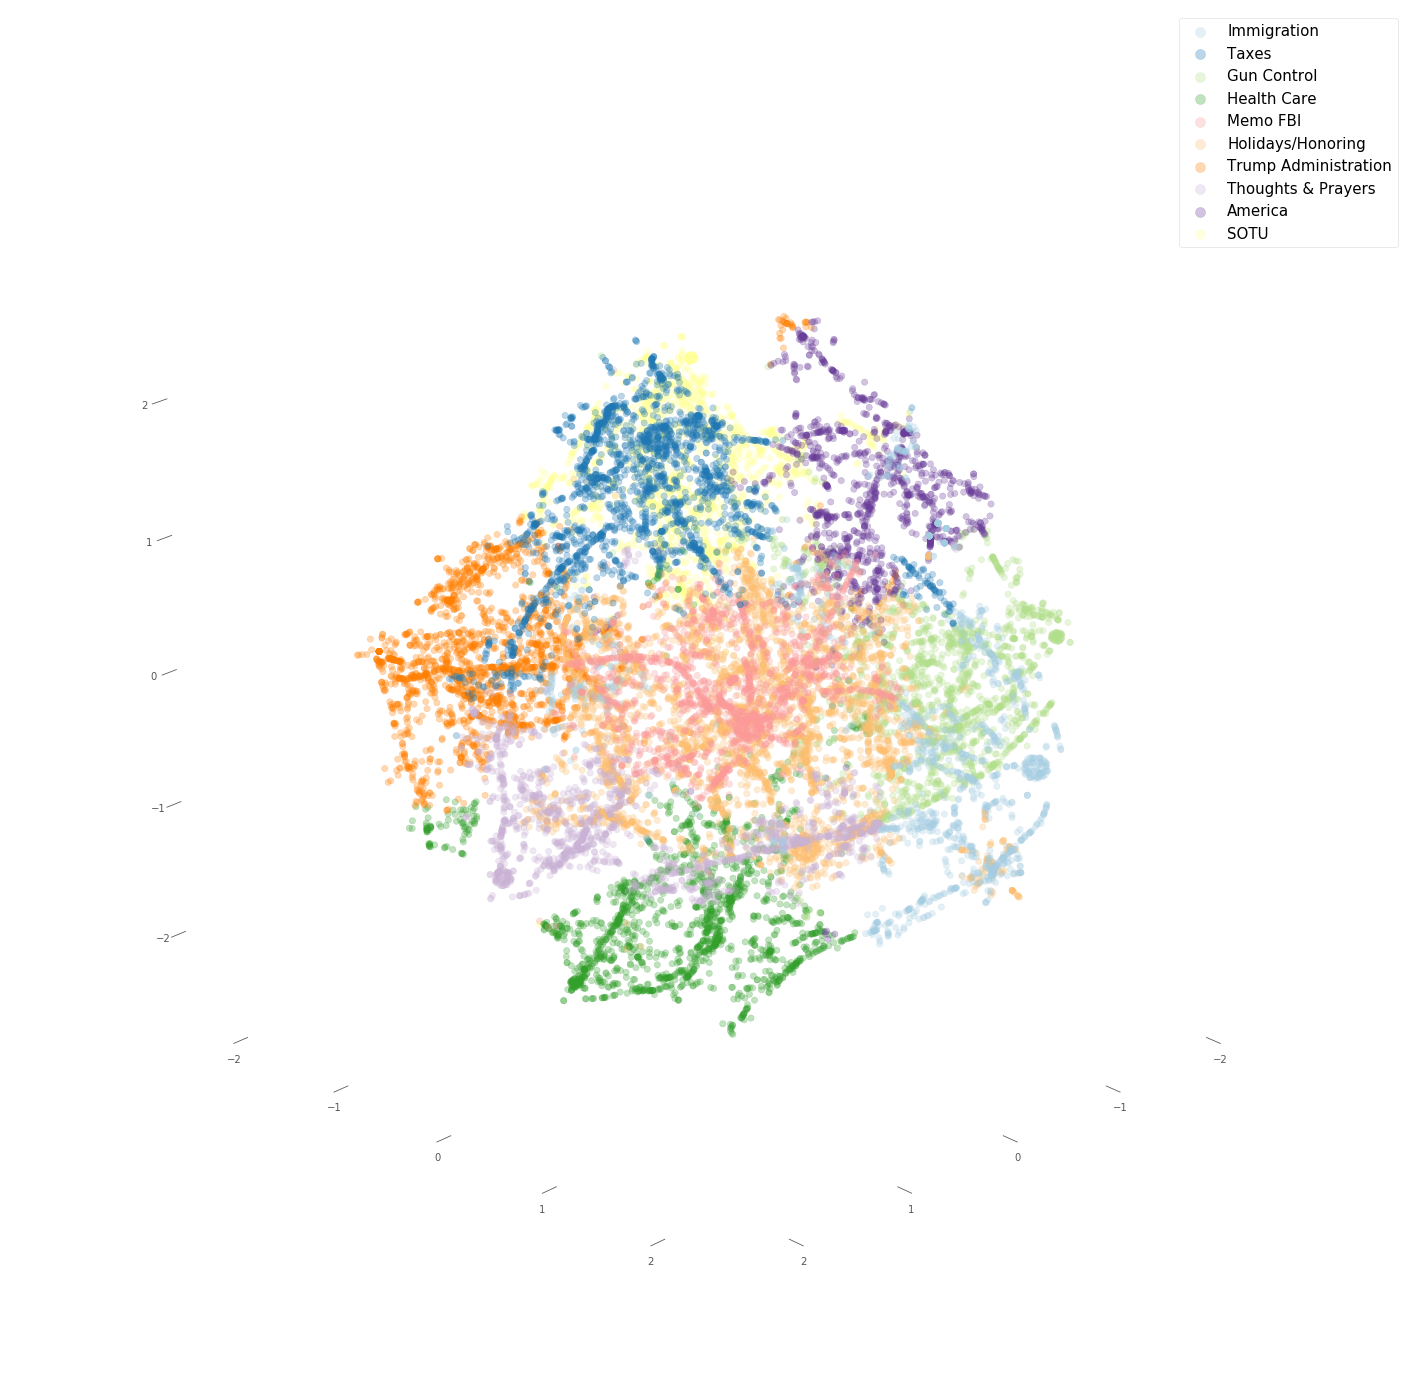

In [55]:
fig = plt.figure(figsize=(25,25), facecolor='white')
ax = fig.add_subplot(111,projection='3d')
ax.set_facecolor((1,1,1))
ax.xaxis.set_pane_color((1,1,1))
ax.yaxis.set_pane_color((1,1,1))
ax.zaxis.set_pane_color((1,1,1))

plt.grid()
plt.rcParams['grid.color'] = "grey"

nb_classes = len(np.unique(label_ids))
    
for label_id in np.unique(label_ids):
    ax.scatter(tsne_result_scaled[np.where(label_ids == label_id), 0],
                tsne_result_scaled[np.where(label_ids == label_id), 1],
                tsne_result_scaled[np.where(label_ids == label_id), 2],
                alpha=0.3,
                color= plt.cm.Paired(label_id / float(nb_classes)),
                marker='o',
                s=40,
                label=id_to_label_dict[label_id])
    
lgnd = ax.legend(loc='best', prop={'size': 15}, facecolor="white")

for i, t in enumerate(topics):
    lgnd.legendHandles[i]._sizes = [100]

ax.view_init(25, 45)
ax.set_xlim(-2.5, 2.5)
ax.set_ylim(-2.5, 2.5)
ax.set_zlim(-2.5, 2.5)

### Try plotting interactive 3D

In [56]:
# Authenticate account with plotly
plotly.tools.set_credentials_file(username=config.get('Plotly', 'user'), 
                                  api_key=config.get('Plotly', 'api_key'))

In [92]:
def remove_newlines(tweet):
    """
    Utility function to remove newline characters from plotly hovertext
    """
    no_url = re.sub(r'http\S+', '', tweet)
    result = ''.join([str(i).replace('\n', ' ') for i in no_url])

    return result

In [100]:
text = [remove_newlines(tweet) for tweet in rawtext]
topic = [id_to_label_dict[id_] for id_ in label_ids]
name = names

statTooltips = ['<b>{}</b> <br> <b>{}</b> <br> {}'.format(t, n, tw) for (t, n, tw) in zip(topic, name, text)]

In [111]:
 data = [go.Scatter3d(
            x = tsne_result_scaled[:,0],
            y = tsne_result_scaled[:,1],
            z = tsne_result_scaled[:,2],
            mode='markers', 
            text=statTooltips,
            hoverinfo='none+none+none+text',
            marker=dict(
                color=plt.cm.Paired(label_ids/ float(nb_classes)),
                size=8,
                opacity=.1,
                line=dict(
                    color=plt.cm.Paired(label_ids/ float(nb_classes)),
                    width=0.5
                ),
            ),
        )] 

In [112]:
layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='simple-3d-scatter')